In [1]:
%pylab inline
import pickle
import glob
import os
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, ".")

import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")


def pd_full(rows=100):
    pd.set_option("display.max_rows", rows)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", "{:20,.3f}".format)
    pd.set_option("display.max_colwidth", None)


pd_full()

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load relevant experiment script
import scripts.run_base_configs_exp as exp
from filternet.training.evalmodel import *

In [3]:
from filternet.datasets.opportunity import get_x_y_contig
from filternet.datasets import sliding_window_x_y
from torch.utils.data import DataLoader, TensorDataset

# REPLACE WITH NEW MODEL
model_dir = 'saved_models/base_configs_7_multi_scale_cnn_lstm_1'
em = load_eval_model_from_dir(model_dir)
# em.run_test_set()
# em.calc_metrics()
# em.calc_ward_metrics()

display(em.classification_report_df)
em.f1, em.f1_mean, em.infer_samples_per_s, em.n_samples_in, em.n_samples_out


,precision,recall,f1-score,support,event_f1
,0.961,0.958,0.959,12337,0.916
Open Door 1,0.573,0.798,0.667,84,0.615
Open Door 2,0.952,0.826,0.885,144,0.933
Close Door 1,0.816,0.705,0.756,88,0.909
Close Door 2,0.846,0.968,0.903,125,0.941
Open Fridge,0.903,0.707,0.793,341,0.982
Close Fridge,0.804,0.924,0.860,236,0.982
Open Dishwasher,0.793,0.745,0.768,149,0.867
Close Dishwasher,0.710,0.644,0.676,118,0.759
Open Drawer 1,0.657,0.746,0.698,59,0.818


(0.922901262411133, 0.7391078048036487, 1062393.8561033506, 236544, 14816)

In [7]:
Xc, ycs, data_spec = get_x_y_contig('test')
dls = {}
win_lens = [
    32, 
    64, 
    128, 
    256, 
    512, 
    1024, 
    1024*2, 
    1024*4, 
    1024* 8, 
     1024*16
]

new_len = int(floor(len(Xc) / np.max(win_lens)) * np.max(win_lens))
print(f'Cropping data from {len(Xc)} to {new_len} for consistency between win_lens')
Xc = Xc[:new_len]
ycs = [yc[:new_len] for yc in ycs]

for win_len in win_lens:
    print(win_len)
    # Properly window data for this model
    X, ys = sliding_window_x_y(
        Xc,
        ycs,
        win_len=win_len,
        step=int(win_len/2),
        shuffle=False,  
    )

    dls[win_len] = DataLoader(
        TensorDataset(torch.Tensor(X), *[torch.Tensor(y).long() for y in ys]),
        batch_size=em.eval_batch_size,
        shuffle=False,
    )

Cropping data from 118750 to 114688 for consistency between win_lens
32
64
128
256
512
1024
2048
4096
8192
16384


In [8]:
results = []

In [9]:

for base_config in ['base_cnn', 'multi_scale_cnn','base_lstm',
       'cnn_lstm',  
                    'multi_scale_cnn_lstm']:
    for i_run in range(2,7):
        model_dir = f'saved_models/base_configs_7_{base_config}_{i_run}'
        print(model_dir)
        em = load_eval_model_from_dir(model_dir)
        
        for win_len in win_lens:
            print(win_len)

            em.cuda = True
            em.device = 'cuda'
            em.model.cuda()
            em.run_test_set(dls[win_len])
            cuda_infer_rate = em.infer_samples_per_s

            em.cuda = False
            em.device = 'cpu'
            em.model.cpu()
            em.run_test_set(dls[win_len])
            cpu_infer_rate = em.infer_samples_per_s

            # Run on this data subset
            em.run_test_set(dls[win_len])
            # Calc new metrics for *just* this subset
            em.calc_metrics()
            em.calc_ward_metrics()

        #     display(em.classification_report_df)
            print(em.f1, em.f1_mean, em.event_f1, int(em.infer_samples_per_s/1000), em.n_samples_in, em.n_samples_out)
            results.append(dict(
                win_len=win_len,
                i_run=i_run,
                model_dir=model_dir,
                base_config=em.trainer.base_config,
                f1=em.f1, 
             f1_mean=em.f1_mean,
             event_f1=em.event_f1,
#              fer_samples_per_s=em.infer_samples_per_s,
             cuda_infer_rate = cuda_infer_rate,
             cpu_infer_rate  = cpu_infer_rate
            ))


saved_models/base_configs_7_base_cnn_2
32


/home/ubuntu/anaconda3/envs/petinsight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/petinsight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9011432902808354 0.6289813468849952 0.634262617887864 175 229312 14334
64
0.9042467438317372 0.6364325453348587 0.655703411005869 199 229248 14332
128
0.9038560874439471 0.6335041498884205 0.6514914180969837 215 229120 14328
256
0.9038025171022163 0.6335024840391479 0.6514914180969837 226 228864 14320
512
0.9037597302516258 0.6335673053955343 0.6524754045010389 232 228352 14304
1024
0.9037118553768979 0.6337717780187508 0.6524754045010389 193 227328 14272
2048
0.9044807124982909 0.6325830755487433 0.6512306978821347 187 225280 14208
4096
0.9080056214713718 0.6332033394324955 0.6511919137707411 193 221184 14080
8192
0.9090682790716609 0.6362504731992707 0.6508269666694652 193 212992 13824
16384
0.9099133970730597 0.6358151323438914 0.6469428007889546 188 196608 13312
saved_models/base_configs_7_base_cnn_3
32
0.8974114163724524 0.6266800239200708 0.6376820022243707 175 229312 14334
64
0.9010465018307515 0.6413567887440701 0.6608287442448316 198 229248 14332
128
0.9007445692981377 0.639

0.86975353019739 0.5123666718481553 0.5477127897065389 97 229312 114672
64
0.8823944152614612 0.5646895808862114 0.532940207063941 99 229248 114656
128
0.890523870342511 0.5902037286667139 0.5610564528857789 99 229120 114624
256
0.8917349372538121 0.5927787069342997 0.5795583105496371 100 228864 114560
512
0.8920333462796426 0.5945391713867534 0.5741848685311823 98 228352 114432
1024
0.8916829494991387 0.5924308637180977 0.5784719332174594 85 227328 114176
2048
0.8924010374992185 0.59173272468693 0.5736576585712113 79 225280 113664
4096
0.8961094460768498 0.5920376856265135 0.5719380129533 79 221184 112640
8192
0.8967920724867909 0.5933166244131794 0.5677036059080781 60 212992 110592
16384
0.8967524506572417 0.5914795144513172 0.5626591230551626 40 196608 106496
saved_models/base_configs_7_base_lstm_3
32
0.8694707330525587 0.4837229260286136 0.5210184684336604 96 229312 114672
64
0.8858951863873842 0.5428504727545514 0.5395916185239131 98 229248 114656
128
0.8951900826452739 0.58605985

0.8616116654682516 0.47052408093726444 0.5251252137531142 118 229312 14334
64
0.8932346381731933 0.6216650292922431 0.6334279312920089 143 229248 14332
128
0.9197751949439973 0.7335710004737815 0.8019879049158735 160 229120 14328
256
0.9299588853744039 0.7601853735917703 0.8656122258142083 167 228864 14320
512
0.9327531961964225 0.762767300941206 0.8722706400524786 182 228352 14304
1024
0.9327315064396142 0.7665245786420541 0.8651133632849233 179 227328 14272
2048
0.9331403682320148 0.7684649671293063 0.8631703735636055 179 225280 14208
4096
0.9361919869257311 0.7701919414883186 0.8654055715443293 182 221184 14080
8192
0.9371367265718199 0.7714879848189902 0.8627176480881967 163 212992 13824
16384
0.9370132156960358 0.7699962487836873 0.8594479560397675 141 196608 13312
saved_models/base_configs_7_multi_scale_cnn_lstm_3
32
0.864294224833914 0.4529544008110498 0.5164353486062732 118 229312 14334
64
0.9011702408352126 0.6190959945527466 0.6445919825195394 142 229248 14332
128
0.926822973

In [13]:
'a' # 4204

'a'

In [14]:
df_results = pd.DataFrame(results)
df_results

,win_len,i_run,model_dir,base_config,f1,f1_mean,event_f1,cuda_infer_rate,cpu_infer_rate
0,32,2,saved_models/base_configs_7_base_cnn_2,base_cnn,0.901,0.629,0.634,"204,048.910","165,350.567"
1,64,2,saved_models/base_configs_7_base_cnn_2,base_cnn,0.904,0.636,0.656,"767,754.632","188,345.886"
2,128,2,saved_models/base_configs_7_base_cnn_2,base_cnn,0.904,0.634,0.651,"871,255.401","220,164.986"
3,256,2,saved_models/base_configs_7_base_cnn_2,base_cnn,0.904,0.634,0.651,"900,465.075","222,963.770"
4,512,2,saved_models/base_configs_7_base_cnn_2,base_cnn,0.904,0.634,0.652,"1,037,409.160","227,854.944"
...,...,...,...,...,...,...,...,...,...
245,1024,6,saved_models/base_configs_7_multi_scale_cnn_lstm_6,multi_scale_cnn_lstm,0.925,0.734,0.823,"872,145.693","179,189.038"
246,2048,6,saved_models/base_configs_7_multi_scale_cnn_lstm_6,multi_scale_cnn_lstm,0.925,0.732,0.819,"873,434.021","178,298.328"
247,4096,6,saved_models/base_configs_7_multi_scale_cnn_lstm_6,multi_scale_cnn_lstm,0.928,0.733,0.822,"912,135.236","180,504.394"
248,8192,6,saved_models/base_configs_7_multi_scale_cnn_lstm_6,multi_scale_cnn_lstm,0.929,0.734,0.818,"755,771.389","163,292.875"


In [15]:
df_results.groupby(['base_config', 'win_len']).mean().sort_index().drop('i_run', axis=1)

f1              f1_mean             event_f1      cuda_infer_rate       cpu_infer_rate
base_config          win_len                                                                                                         
base_cnn             32                     0.897                0.622                0.631          534,067.240          173,354.565
                     64                     0.900                0.635                0.648          774,815.692          196,823.871
                     128                    0.900                0.635                0.647          891,083.030          219,040.734
                     256                    0.900                0.635                0.648          886,213.649          222,439.683
                     512                    0.900                0.635                0.648        1,046,012.019          228,054.023
                     1024                   0.900                0.635                0.648          925,310.313          192,699.021
                     2048                   0.901                0.634                0.645          950,133.870          188,846.277
                     4096                   0.904                0.634                0.646          951,064.077          183,906.555
                     8192                   0.905                0.637                0.645          996,934.088          189,445.846
                     16384                  0.907                0.637                0.642          956,876.101          189,444.203
base_lstm            32                     0.872                0.509                0.551          534,472.309           95,733.695
                     64                     0.886                0.564                0.549          603,873.537           97,197.635
                     128                    0.894                0.597                0.568          643,070.113           99,422.867
                     256                    0.895                0.602                0.577          633,465.349           99,030.498
                     512                    0.895                0.599                0.575          707,284.730           97,618.402
                     1024                   0.895                0.598                0.574          574,818.073           85,624.507
                     2048                   0.896                0.596                0.572          491,532.511           79,421.911
                     4096                   0.899                0.598                0.571          492,994.147           77,904.637
                     8192                   0.900                0.599                0.569          321,291.906           59,810.029
                     16384                  0.901                0.598                0.565          173,755.648           39,791.879
cnn_lstm             32                     0.867                0.459                0.516          586,490.792          131,758.669
                     64                     0.893                0.590                0.639          652,917.606          154,191.323
                     128                    0.914                0.684                0.764          772,445.714          170,391.224
                     256                    0.921                0.714                0.808          783,421.017          177,558.772
                     512                    0.922                0.717                0.824        1,002,271.766          192,720.602
                     1024                   0.922                0.715                0.828          851,682.068          190,001.408
                     2048                   0.922                0.712                0.825          818,401.717          187,934.747
                     4096                   0.925                0.713                0.825          837,928.342          190,074.858
                     8192  

In [16]:
# CHECKPOINT
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
fn =  f"win_len_timings_df_{timestr}.pkl"
df_results.to_pickle(fn)
fn

'win_len_timings_df_20200209-153419.pkl'

In [ ]:
raise Exception() # So we don't automatically run through this
# must change filename below to match above.

In [4]:
fn = 'win_len_timings_df_20200209-153419.pkl'
df = pd.read_pickle(fn)
df.cuda_infer_rate /= 1000
df.cpu_infer_rate /= 1000

In [5]:
df.base_config.unique()

array(['base_cnn', 'multi_scale_cnn', 'base_lstm', 'cnn_lstm',
       'multi_scale_cnn_lstm'], dtype=object)

In [6]:
df.groupby(['base_config', 'win_len']).i_run.count()

base_config           win_len
base_cnn              32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      4096       5
                      8192       5
                      16384      5
base_lstm             32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      4096       5
                      8192       5
                      16384      5
cnn_lstm              32         5
                      64         5
                      128        5
                      256        5
                      512        5
                      1024       5
                      2048       5
                      409

In [7]:
df.groupby(['base_config', 'win_len']).i_run.max()

base_config           win_len
base_cnn              32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      4096       6
                      8192       6
                      16384      6
base_lstm             32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      4096       6
                      8192       6
                      16384      6
cnn_lstm              32         6
                      64         6
                      128        6
                      256        6
                      512        6
                      1024       6
                      2048       6
                      409

In [8]:
df2 = df.groupby(['base_config', 'win_len']).mean().sort_index().drop('i_run', axis=1)
df2

f1              f1_mean             event_f1      cuda_infer_rate       cpu_infer_rate
base_config          win_len                                                                                                         
base_cnn             32                     0.897                0.622                0.631              534.067              173.355
                     64                     0.900                0.635                0.648              774.816              196.824
                     128                    0.900                0.635                0.647              891.083              219.041
                     256                    0.900                0.635                0.648              886.214              222.440
                     512                    0.900                0.635                0.648            1,046.012              228.054
                     1024                   0.900                0.635                0.648              925.310              192.699
                     2048                   0.901                0.634                0.645              950.134              188.846
                     4096                   0.904                0.634                0.646              951.064              183.907
                     8192                   0.905                0.637                0.645              996.934              189.446
                     16384                  0.907                0.637                0.642              956.876              189.444
base_lstm            32                     0.872                0.509                0.551              534.472               95.734
                     64                     0.886                0.564                0.549              603.874               97.198
                     128                    0.894                0.597                0.568              643.070               99.423
                     256                    0.895                0.602                0.577              633.465               99.030
                     512                    0.895                0.599                0.575              707.285               97.618
                     1024                   0.895                0.598                0.574              574.818               85.625
                     2048                   0.896                0.596                0.572              491.533               79.422
                     4096                   0.899                0.598                0.571              492.994               77.905
                     8192                   0.900                0.599                0.569              321.292               59.810
                     16384                  0.901                0.598                0.565              173.756               39.792
cnn_lstm             32                     0.867                0.459                0.516              586.491              131.759
                     64                     0.893                0.590                0.639              652.918              154.191
                     128                    0.914                0.684                0.764              772.446              170.391
                     256                    0.921                0.714                0.808              783.421              177.559
                     512                    0.922                0.717                0.824            1,002.272              192.721
                     1024                   0.922                0.715                0.828              851.682              190.001
                     2048                   0.922                0.712                0.825              818.402              187.935
                     4096                   0.925                0.713                0.825              837.928              190.075
                     8192  

In [9]:
df3 = df2.loc['base_cnn']

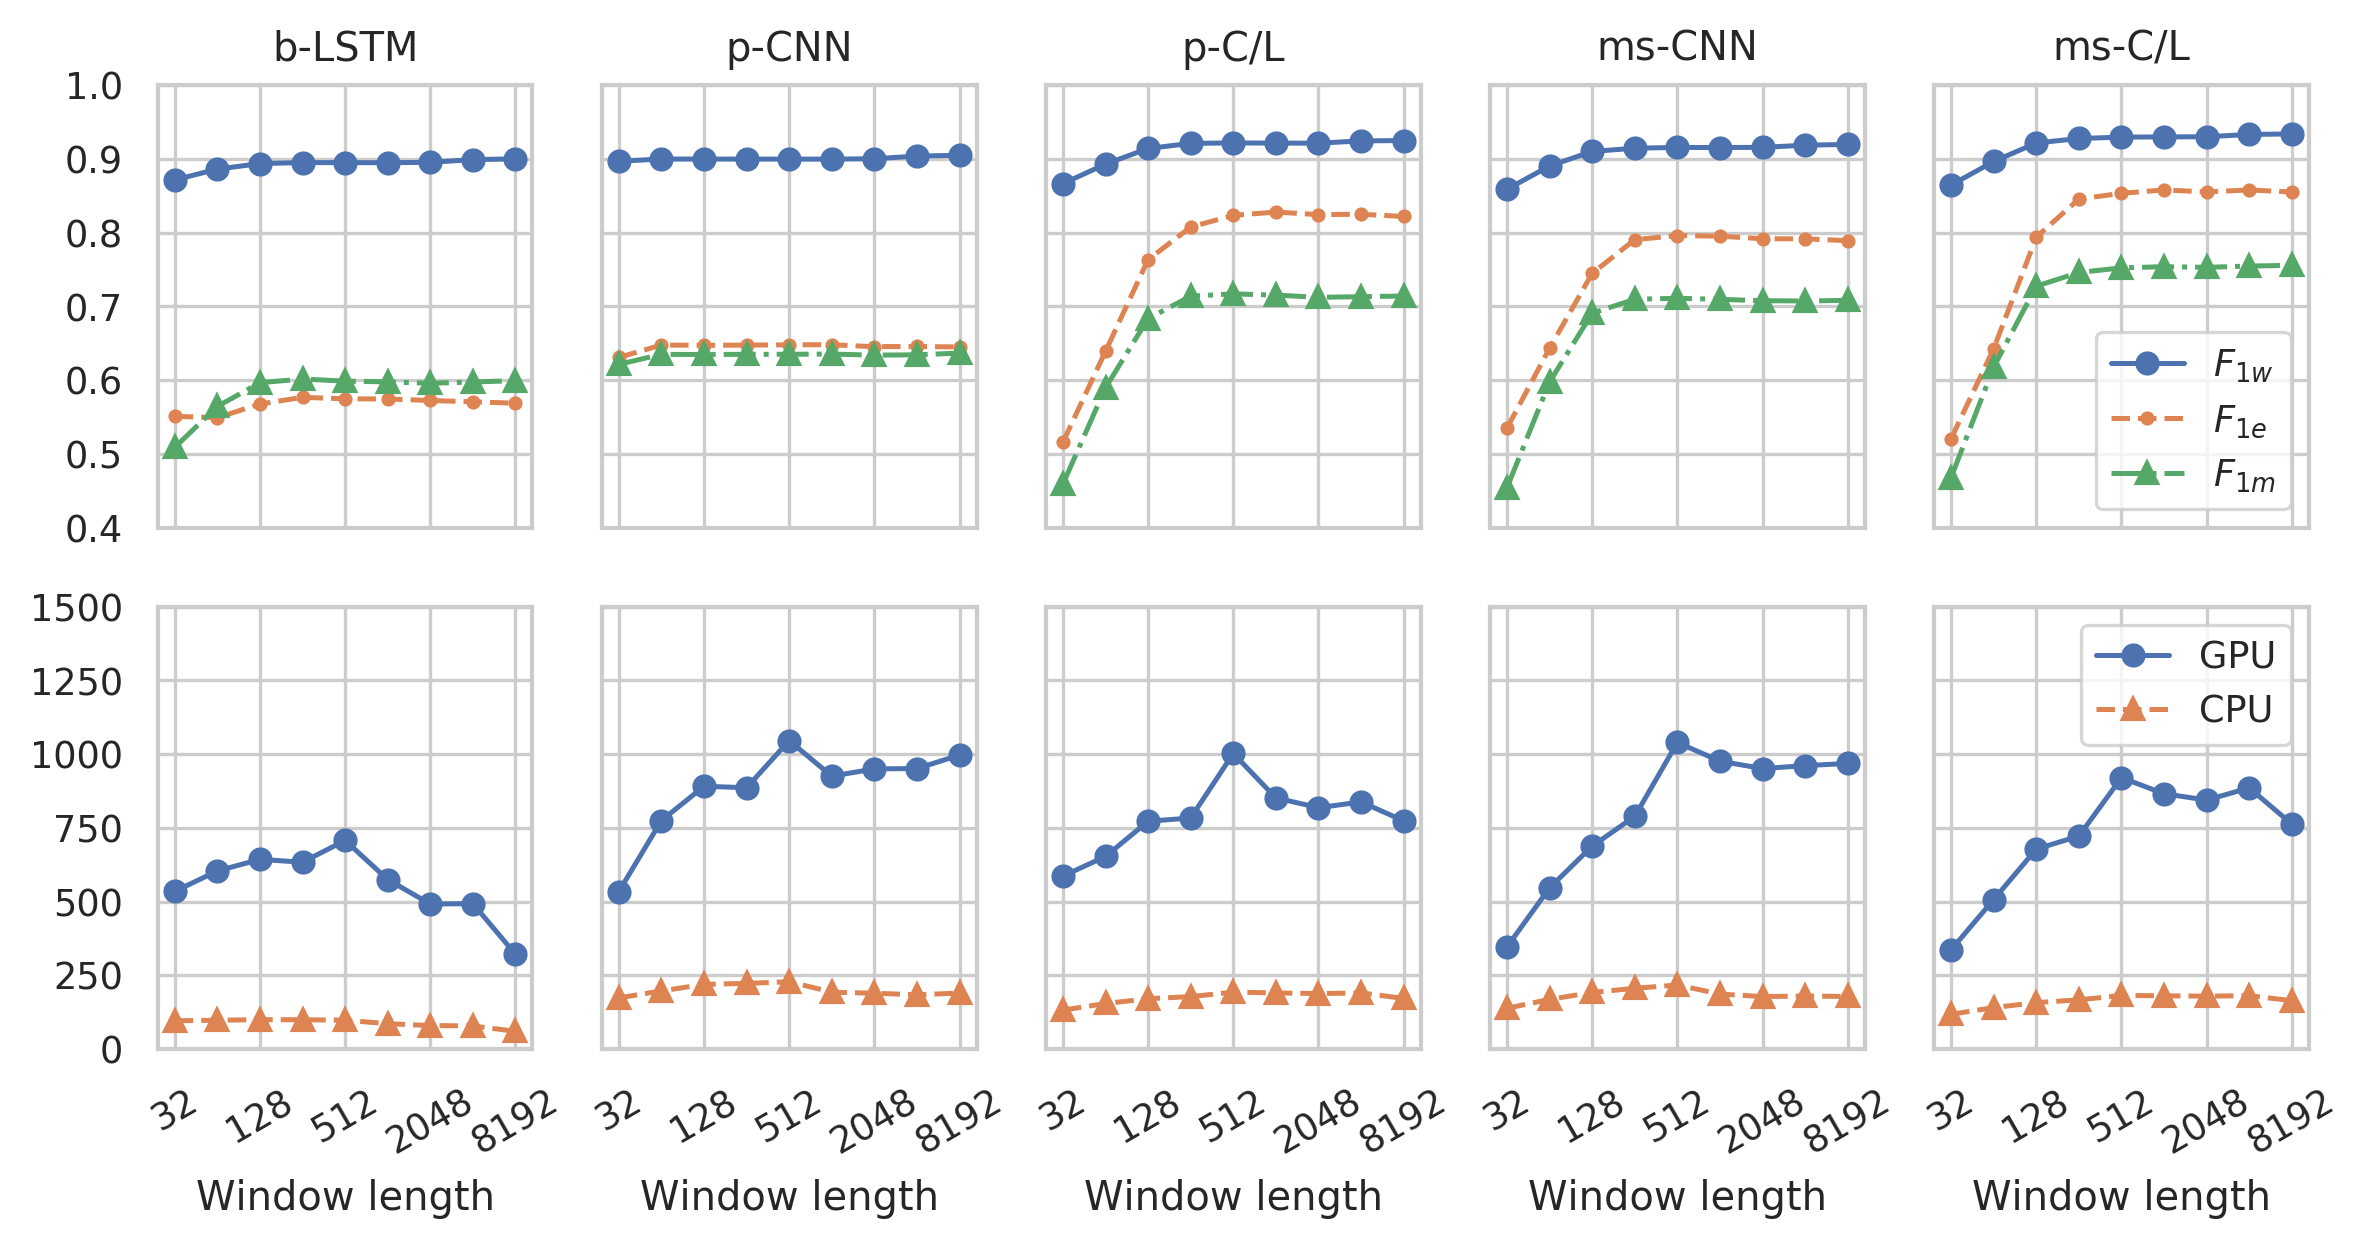

In [11]:
configs = [
    ['base_lstm'],
    ['base_cnn'],
    ['cnn_lstm'],
     ['multi_scale_cnn'], 
    ['multi_scale_cnn_lstm'],
]
names = [
    'b-LSTM',
    'p-CNN',
    'p-C/L',
    'ms-CNN',
    'ms-C/L'
]
def set_legend(legend_names, legend_title=None, ax=None):
    if ax is None:
        ax = gca()
    ax.get_legend().set_title(legend_title)
    # replace labels
    for t, l in zip(ax.get_legend().texts, legend_names): 
        t.set_text(l)

scale = .8
kwargs = dict( kind='point', dodge=True,
              ci="sd", capsize=.2, linestyles=['-', '--', '-.'], 
              markers = ['o', '.', '^'], scale=scale)

f, axes = subplots(2,len(configs), figsize=[1.6 * len(configs),4.25], dpi=300, sharex=True)
for i, (base_config,) in enumerate(configs):
    df5 = df2.loc[base_config].iloc[:-1,:]

    sca(axes[0][i])
    gca().set_xscale('log')
    
    plot(df5.index, df5.f1, 'o-', color=sns.palettes.color_palette()[0], label='$F_{1w}$')
    plot(df5.index, df5.event_f1, '.--', color=sns.palettes.color_palette()[1], label='$F_{1e}$')
    plot(df5.index, df5.f1_mean, '^-.', color=sns.palettes.color_palette()[2], label='$F_{1m}$')

    
#     ff = sns.pointplot(data=df3, x="win_len", y="value", hue='Metric',
#                        hue_order=["f1", "event_f1", "f1_mean"],
#                        **kwargs)

#     set_legend(['F1 (weighted)', 'F1 (mean)', 'Event F1'])

    title(names[i])
    ylim([.4, 1])
    xlabel(None)
    if i == len(configs)-1:
        ylabel('F1 metric value')
        legend(loc='lower right')
    
    gca().label_outer()
    
#     df3 =  pd.melt(df.query('base_config == @base_config'), id_vars=['base_config', 'win_len'], value_vars=['cuda_infer_rate', 'cpu_infer_rate'],
#                   var_name='Metric')
    sca(axes[1][i])
#     ff = sns.pointplot(data=df3, x="win_len", y="value", hue='Metric',**kwargs)
#     set_legend(['F1 (weighted)', 'Event F1'], #'Metric'
#         )
    plot(df5.index, df5.cuda_infer_rate, 'o-', color=sns.palettes.color_palette()[0], label='GPU')
    plot(df5.index, df5.cpu_infer_rate, '^--', color=sns.palettes.color_palette()[1], label='CPU')


    ylim([0, 1500])
#     xlim([0, None])

    xticks(df5.index[::2], [str(w) for w in df5.index[::2]], rotation=30)
    xlabel('Window length')
    if i == len(configs)-1:
        ylabel('Infer Rate [ksamp/s]')
        legend(loc='upper right')
        
    gca().label_outer()
    
    
tight_layout(w_pad=0.5)#w_pad=3)
plt.savefig('win_len_effects.png')

In [34]:
df5

,f1,f1_mean,event_f1,cuda_infer_rate,cpu_infer_rate
win_len,,,,,
32,0.865,0.468,0.521,336.448,117.622
64,0.897,0.618,0.643,506.961,140.226
128,0.922,0.728,0.794,677.960,157.164
256,0.928,0.746,0.846,722.158,166.581
512,0.930,0.752,0.854,920.261,181.492
1024,0.930,0.754,0.858,865.784,180.299
2048,0.930,0.753,0.855,844.202,179.017
4096,0.933,0.755,0.858,885.588,180.855
8192,0.934,0.756,0.855,762.912,163.763
